# Correlation between weather and rents

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, time, datetime, timedelta 
import seaborn as sns

df_weather_2019 = pd.read_csv("weather_2019.csv", sep=",")
Dataset = pd.read_csv('boston_2019.csv', sep=',')
df_rents = pd.DataFrame(Dataset['start_time'])
df_rents['start_time'] = pd.to_datetime(df_rents.start_time)
df_weather_2019['date_time'] = pd.to_datetime(df_weather_2019.date_time)

# round start_time values to next nearest hour
# name it datetime so that it can be merged with the dates of the weather dataset
df_rents['date_time'] = df_rents['start_time'].dt.round('60min')
df_rents = df_rents.drop('start_time', axis='columns')

df_RentsPerTemp = df_rents.merge(df_weather_2019, on='date_time')

# assign a temperature intervall to each rent 

def transform_temp_to_intervall(x):
    if x < -5:
        return '[< -5]'
    if x >= -5 and x <= 0 :
        return '[-5, 0]'
    if x > 0 and x <= 5:
        return '[1, 5]'
    if x > 5 and x <= 10:
        return '[6, 10]'
    if x > 10 and x <= 15:
        return '[11, 15]'
    if x > 15 and x <= 20:
        return '[16, 20]'
    if x > 20 and x <= 25:
        return '[21, 25]'
    if x > 25:
        return '[> 25]'
    
df_RentsPerTemp['max_temp_intervall'] = df_RentsPerTemp['max_temp'].apply(transform_temp_to_intervall)
df_RentsPerTemp['min_temp_intervall'] = df_RentsPerTemp['min_temp'].apply(transform_temp_to_intervall)
df_RentsPerTemp

,date_time,Unnamed: 0,max_temp,min_temp,precip,max_temp_intervall,min_temp_intervall
0,2019-01-01 00:00:00,35063,5.6,5.6,1.0,"[6, 10]","[6, 10]"
1,2019-01-01 01:00:00,35040,3.9,3.9,1.0,"[1, 5]","[1, 5]"
2,2019-01-01 01:00:00,35040,3.9,3.9,1.0,"[1, 5]","[1, 5]"
3,2019-01-01 01:00:00,35040,3.9,3.9,1.0,"[1, 5]","[1, 5]"
4,2019-01-01 01:00:00,35040,3.9,3.9,1.0,"[1, 5]","[1, 5]"
...,...,...,...,...,...,...,...
2381265,2019-12-31 00:00:00,43776,3.9,2.8,0.0,"[1, 5]","[1, 5]"
2381266,2019-12-31 00:00:00,43776,3.9,2.8,0.0,"[1, 5]","[1, 5]"
2381267,2019-12-31 00:00:00,43776,3.9,2.8,0.0,"[1, 5]","[1, 5]"
2381268,2019-12-31 00:00:00,43776,3.9,2.8,0.0,"[1, 5]","[1, 5]"


In [2]:
min_temp_count = df_RentsPerTemp.min_temp_intervall.value_counts()
max_temp_count = df_RentsPerTemp.max_temp_intervall.value_counts()

df_intervall_counts = pd.concat([max_temp_count, min_temp_count], axis=1)
df_intervall_counts = df_intervall_counts.rename(columns = {'max_temp_intervall': 'max_temp_count', 'min_temp_intervall': 'min_temp_count'}, inplace = False)
df_intervall_counts.index.names = ['interval']
df_intervall_counts

,max_temp_count,min_temp_count
interval,,
"[21, 25]",568115,564852
"[16, 20]",476117,479036
"[11, 15]",406291,407812
[> 25],374667,370459
"[6, 10]",236394,237124
"[1, 5]",194374,195931
"[-5, 0]",99184,99927
[< -5],26128,26129


Since the values of max and min temperatures don't differ too much, we will continue working with the maximum temperature values.

In [3]:
df_intervall_counts = df_intervall_counts.rename(columns={"max_temp_count": "temp_count"})
df_intervall_counts.drop(['min_temp_count'], axis=1)

,temp_count
interval,
"[21, 25]",568115
"[16, 20]",476117
"[11, 15]",406291
[> 25],374667
"[6, 10]",236394
"[1, 5]",194374
"[-5, 0]",99184
[< -5],26128


### Correlation between precip and rents

In [4]:
# get number of rents that took place on rainy vs non-rainy days, 1.0 = rain, 0.0 = no rain
rain_count = df_RentsPerTemp.precip.value_counts()
rain_count

0.0    2258546
1.0     122724
Name: precip, dtype: int64

# Data Visualization

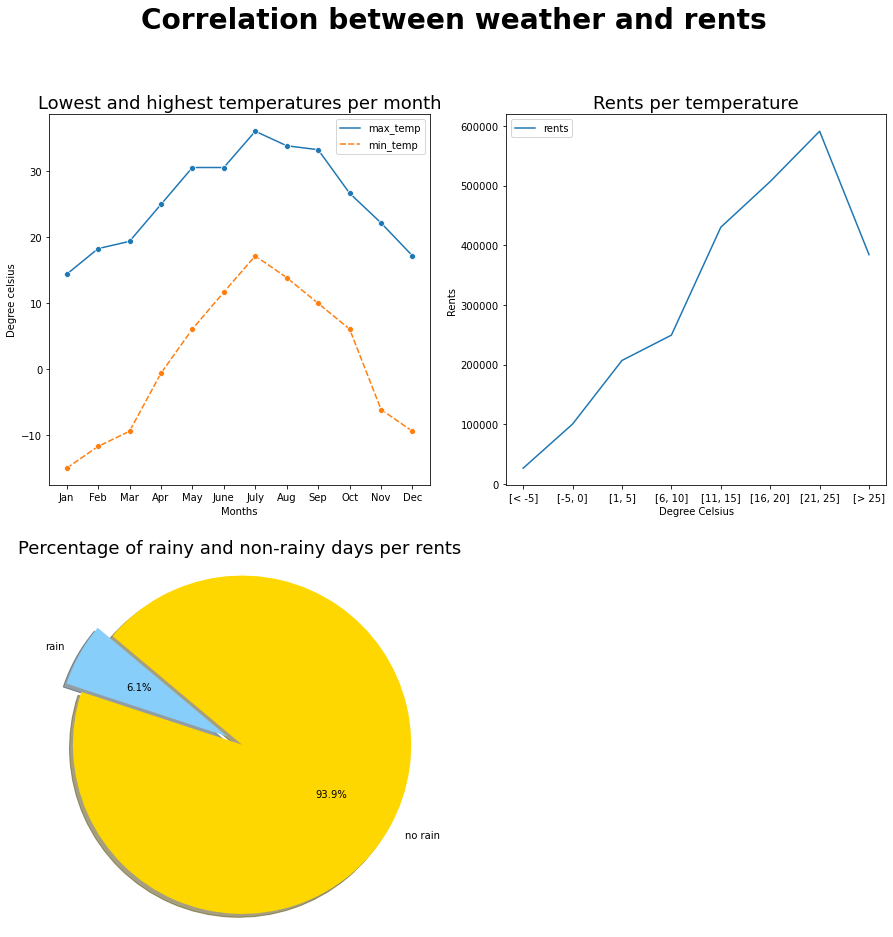

In [5]:
fig = plt.figure(figsize=(15, 15))
fig.suptitle("Correlation between weather and rents", fontsize=28, fontweight='bold')

df_weather_2019 = pd.read_csv('weather_2019.csv', sep=',')
df_weather_2019["date_time"] = pd.to_datetime(df_weather_2019["date_time"], infer_datetime_format=True)

monthly_index = df_weather_2019.set_index('date_time')
df19_monthly= monthly_index.resample('M').agg({'max_temp': np.max, 'min_temp': np.min})
df19_monthly['months'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df19_monthly.set_index(['months'],inplace=True)

subplotTempPerMonth = fig.add_subplot(2,2,1)
subplotTempPerMonth = sns.lineplot(data = df19_monthly, marker='o')
plt.title('Lowest and highest temperatures per month', size = 18)
plt.xlabel('Months')
plt.ylabel('Degree celsius')

df_rentCountsPerTempIntervall = pd.DataFrame({"rents": [26387, 100366, 206996, 249438, 430335, 506959, 591260, 384334]}, index=['[< -5]', '[-5, 0]', '[1, 5]', '[6, 10]', '[11, 15]', '[16, 20]', '[21, 25]', '[> 25]'])

subplotRentsPerTemperature = fig.add_subplot(2, 2, 2)
subplotRentsPerTemperature = sns.lineplot(data = df_rentCountsPerTempIntervall)
plt.title('Rents per temperature', size = 18)
plt.xlabel('Degree Celsius')
plt.ylabel('Rents')
plt.legend()

# Correlation precip and rents
subplotPrecipRents = fig.add_subplot(2, 2, 3)
labels = 'rain', 'no rain'
sizes=[151124, 2344951]
colors = ['lightskyblue', 'gold']
explode = (0.1, 0)
subplotPrecipRents = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage of rainy and non-rainy days per rents', fontsize=18)
plt.axis('equal')

fig.savefig("CorrelationWeatherRents.png")
fig.savefig("CorrelationWeatherRents.pdf")